# The Organizations API: Features Overview

This tutorial provides an overview of the [Organizations data source](https://docs.dimensions.ai/dsl/datasource-organizations.html) available via the [Dimensions Analytics API](https://docs.dimensions.ai/dsl/). 

Organizations data in Dimensions is based on [GRID](https://grid.ac/) - the Global Research Identifiers Database. 

The topics covered in this notebook are:

* How to align your affiliation data with GRID/Dimensions using the API [disambiguation service](https://docs.dimensions.ai/dsl/functions.html#function-extract-affiliations)  
* How to retrieve organizations metadata using the [search fields](https://docs.dimensions.ai/dsl/datasource-organizations.html) available
* How to use the [schema API](https://docs.dimensions.ai/dsl/data-sources.html#metadata-api) to obtain some statistics about the Organizations data available  
 


## Prerequisites

Please install the latest versions of these libraries to run this notebook. 

In [5]:
!pip install dimcli tqdm plotly -U --quiet

import dimcli
from dimcli.shortcuts import *
import json
import sys
import time
import pandas as pd
from tqdm.notebook import tqdm as pbar
import plotly.express as px  # plotly>=4.8.1
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://github.com/digital-science/dimcli#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  USERNAME = getpass.getpass(prompt='Username: ')
  PASSWORD = getpass.getpass(prompt='Password: ')
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
else:
  USERNAME, PASSWORD  = "", ""
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.7.2)
Connected to: https://app.dimensions.ai - DSL v1.26
Method: dsl.ini file


---

## 1. Matching affiliation data to GRID IDs using `extract_affiliations`

The API function `extract_affiliations` ([docs](https://docs.dimensions.ai/dsl/functions.html#function-extract-affiliations)) can be used to enrich private datasets including non-disambiguated organizations data with Dimensions IDs, so to then take advantage of the wealth of linked data available in Dimensions.

For example, let's assume our dataset has four columns (*affiliation name*, *city*, *state* and *country*) - any of which can be empty of course. Like this:


In [6]:
affiliations = [
                ['University of Nebraska–Lincoln', 'Lincoln', 'Nebraska', 'United States'],
                ['Tarbiat Modares University', 'Tehran', '', 'Iran'],
                ['Harvard University', 'Cambridge', 'Massachusetts', 'United States'],
                ['China Academy of Chinese Medical Sciences', 'Beijing', '', 'China'],
                ['Liaoning University', 'Shenyang', '', 'China'],
                ['Liaoning Normal University', 'Dalian', '', 'China'],
                ['P.G. Department of Zoology and Research Centre, Shri Shiv Chhatrapati College of Arts, Commerce and Science, Junnar 410502, Pune, India.', '', '', ''],
                ['Sungkyunkwan University', 'Seoul', '', 'South Korea'],
                ['Centre for Materials for Electronics Technology', 'Pune', '', 'India'],
                ['Institut Necker-Enfants Malades (INEM), INSERM U1151-CNRS UMR8253, Université de Paris, Faculté de Médecine, 156 rue de Vaugirard, 75730 Paris Cedex 15, France', '', '', '']
                ]

We want to look up GRID identifiers for those affiliations using the **structured** affiliation matching. 

In [7]:
for d in pbar(affiliations):
    res = dsl.query(f"""extract_affiliations(name="{d[0]}", city="{d[1]}", state="{d[2]}", country="{d[3]}")""")
    time.sleep(0.5)
    print(res.json)

{'results': [{'institutes': [{'institute': {'id': 'grid.24434.35', 'name': 'University of Nebraska–Lincoln', 'city': 'Lincoln', 'state': 'Nebraska', 'country': 'United States'}, 'metadata': {'requires_manual_review': False}}], 'geo': {'cities': [{'geonames_id': 5072006, 'name': 'Lincoln'}], 'states': [{'geonames_id': 5073708, 'name': 'Nebraska', 'code': 'US-NE'}], 'countries': [{'geonames_id': 6252001, 'name': 'United States', 'code': 'US'}]}, 'input': {'name': 'University of Nebraska–Lincoln', 'city': 'Lincoln', 'state': 'Nebraska', 'country': 'United States'}}]}
{'results': [{'institutes': [{'institute': {'id': 'grid.412266.5', 'name': 'Tarbiat Modares University', 'city': 'Tehran', 'state': None, 'country': 'Iran'}, 'metadata': {'requires_manual_review': False}}], 'geo': {'cities': [{'geonames_id': 112931, 'name': 'Tehran'}], 'states': [{'geonames_id': 110791, 'name': 'Tehran', 'code': None}], 'countries': [{'geonames_id': 130758, 'name': 'Iran', 'code': 'IR'}]}, 'input': {'name': '

If we combine the affiliation data into a single long string, we can also perform the same king of operation using the **unstructured** affiliation matching. 

In [8]:
# implicit results 
for d in pbar(affiliations):
    merged = f"{d[0]} {d[1]} {d[2]} {d[3]}"
    res = dsl.query(f"""extract_affiliations(affiliation="{merged}")""")
    time.sleep(0.5)
    print(res.json)

{'results': [{'matches': [{'affiliation_part': 'University of Nebraska–Lincoln Lincoln Nebraska United States', 'institutes': [{'institute': {'id': 'grid.24434.35', 'name': 'University of Nebraska–Lincoln', 'city': 'Lincoln', 'state': 'Nebraska', 'country': 'United States'}, 'metadata': {'requires_manual_review': False}}], 'geo': {'cities': [{'geonames_id': 5072006, 'name': 'Lincoln'}], 'states': [{'geonames_id': 5073708, 'name': 'Nebraska', 'code': 'US-NE'}], 'countries': [{'geonames_id': 6252001, 'name': 'United States', 'code': 'US'}]}}], 'input': {'affiliation': 'University of Nebraska–Lincoln Lincoln Nebraska United States'}}]}
{'results': [{'matches': [{'affiliation_part': 'Tarbiat Modares University Tehran Iran', 'institutes': [{'institute': {'id': 'grid.412266.5', 'name': 'Tarbiat Modares University', 'city': 'Tehran', 'state': None, 'country': 'Iran'}, 'metadata': {'requires_manual_review': False}}], 'geo': {'cities': [{'geonames_id': 112931, 'name': 'Tehran'}], 'states': [{'g

> NOTE: the above commands also support **bulk querying** e.g. to save up API queries - check out the [docs](https://docs.dimensions.ai/dsl/functions.html#function-extract-affiliations) for more info.

## 2. Searching GRID organizations 

This can be done using full text search and/or fielded search. 


### Full-text search 

In [9]:
%%dsldf 
search organizations 
  for "new york" 
return organizations limit 10

Returned Organizations: 10 (total = 231)


,id,state_name,latitude,city_name,country_name,types,linkout,longitude,name
0,grid.454120.6,New York,40.720634,New York,United States,[Facility],[http://www.seagrant.sunysb.edu/],-73.984740,New York Sea Grant
1,grid.480917.3,New York,40.758870,New York,United States,[Nonprofit],[http://www.nycommunitytrust.org/],-73.968185,New York Community Trust
2,grid.480921.6,New York,40.747960,New York,United States,[Nonprofit],[http://nyf.org/],-73.984010,New York Foundation
3,grid.481403.a,New York,40.756190,Manhattan,United States,[Other],[http://www.nytco.com/],-73.990425,New York Times
4,grid.419997.b,New York,40.718030,New York,United States,[Education],[http://www.nyls.edu/],-74.007034,New York Law School
5,grid.429147.d,New York,42.886063,Buffalo,United States,[Healthcare],[https://www.healthnowny.com/],-78.882550,HealthNow New York
6,grid.429893.d,New York,NaN,New York,United States,NaN,NaN,NaN,New York Restoration Project
7,grid.429894.a,New York,40.750397,New York,United States,[Other],[http://www.nypublicradio.org/],-74.994910,New York Public Radio
8,grid.430815.b,New York,40.721195,New York,United States,[Facility],[http://lifelabsnewyork.com/],-73.948240,Lifelabs New York
9,grid.430872.a,New York,NaN,Albany,United States,NaN,NaN,NaN,New York State PTA


In [10]:
%%dsldf 
search organizations 
  for "new york AND community" 
return organizations limit 10

Returned Organizations: 7 (total = 7)


,city_name,longitude,state_name,types,country_name,linkout,latitude,name,id,acronym
0,New York,-73.968185,New York,[Nonprofit],United States,[http://www.nycommunitytrust.org/],40.758870,New York Community Trust,grid.480917.3,NaN
1,Syracuse,-76.148210,New York,[Nonprofit],United States,[https://www.cnycf.org/],43.056038,Central New York Community Foundation,grid.478715.8,CNYCF
2,New York,NaN,New York,NaN,United States,NaN,NaN,Korean Community Services of Metropolitan New ...,grid.429257.f,NaN
3,New York,-73.974620,New York,[Other],United States,[http://www.cssny.org/],40.749622,Community Service Society of New York,grid.475804.a,CSS
4,Buffalo,-78.849690,New York,[Other],United States,[https://hfwcny.org/],42.874810,Health Foundation for Western & Central New York,grid.490742.c,NaN
5,New York,-73.992470,New York,[Other],United States,[http://www.ltccc.org/],40.751163,Long Term Care Community Coalition,grid.475783.a,LTCCC
6,Williamsville,-78.721660,New York,[Education],United States,[https://www.ecc.edu/],42.960820,Erie Community College,grid.468887.d,ECC


### Fielded search 

We can easily look up an organization using its grid ID, eg [grid.468887.d](https://grid.ac/institutes/grid.468887.d). 

In [11]:
%%dsldf 
search organizations 
  where id="grid.468887.d" 
return organizations[all] 

Returned Organizations: 1 (total = 1)


,established,wikipedia_url,country_name,linkout,latitude,orgref_ids,city_name,ror_ids,state_name,isni_ids,name,id,organization_parent_ids,acronym,types,wikidata_ids,longitude
0,1946,https://en.wikipedia.org/wiki/Erie_Community_C...,United States,[https://www.ecc.edu/],42.96082,[529952],Williamsville,[https://ror.org/00tqjtg68],New York,[0000 0004 0447 5070],Erie Community College,grid.468887.d,[grid.189747.4],ECC,[Education],[Q5388284],-78.72166


In [12]:
%%dsldf 
search organizations 
  for "new york" 
  where types in ["Education"]
return organizations limit 10

Returned Organizations: 10 (total = 71)


,linkout,state_name,id,country_name,types,name,longitude,city_name,latitude,acronym
0,[http://www.nyls.edu/],New York,grid.419997.b,United States,[Education],New York Law School,-74.007034,New York,40.718030,NaN
1,[http://www.davisny.edu/],New York,grid.454538.b,United States,[Education],Davis College - New York,-75.961510,Johnson City,42.101124,NaN
2,[http://www.concordia-ny.edu/],New York,grid.468709.4,United States,[Education],Concordia College - New York,-73.821900,Bronxville,40.942413,NaN
3,[https://www.york.cuny.edu/],New York,grid.268456.b,United States,[Education],"York College, City University of New York",-73.795000,New York,40.702000,NaN
4,[http://www.nymc.edu/],New York,grid.260917.b,United States,[Education],New York Medical College,-73.809750,Valhalla,41.085327,NYMC
5,[https://www.artinstitutes.edu/new-york],New York,grid.432135.2,United States,[Education],Art Institute of New York,-73.989220,New York,40.755123,NaN
6,[http://www.nycc.edu/],New York,grid.464639.a,United States,[Education],New York Chiropractic College,-76.756470,Seneca Falls,42.911892,NYCC
7,[http://www.nyu.edu/],New York,grid.137628.9,United States,[Education],New York University,-73.995000,New York,40.730000,NYU
8,[https://www.suny.edu/],New York,grid.189747.4,United States,[Education],State University of New York,-73.749590,Albany,42.648064,SUNY
9,[http://www.nyit.edu/],New York,grid.260914.8,United States,[Education],New York Institute of Technology,-73.982590,New York,40.769943,NYIT


In [13]:
%%dsldf 
search organizations 
  for "new york" 
  where types in ["Education"]
  and country_name != "United States"
return organizations limit 10

Returned Organizations: 8 (total = 8)


,city_name,longitude,types,acronym,country_name,linkout,latitude,name,id,state_name
0,Tirana,19.801466,[Education],UNYT,Albania,[http://unyt.edu.al/],41.311060,University of New York Tirana,grid.444973.9,NaN
1,Prague,14.433994,[Education],UNYP,Czechia,[https://www.unyp.cz/],50.074043,University of New York in Prague,grid.449989.1,NaN
2,Florence,11.265850,[Education],NYU,Italy,[http://www.nyu.edu/florence.html],43.795910,New York University,grid.473731.5,NaN
3,Paris,2.346863,[Education],NaN,France,[http://www.nyu.edu/paris.html],48.869614,New York University Paris,grid.479986.d,NaN
4,Seoul,126.666770,[Education],NaN,South Korea,[http://www.sunykorea.ac.kr/],37.377018,SUNY Korea,grid.410685.e,NaN
5,Vancouver,-123.116480,[Education],NYIT,Canada,[http://nyit.edu/vancouver],49.284374,New York Institute of Technology,grid.473728.d,British Columbia
6,Shanghai,121.533510,[Education],NaN,China,[https://shanghai.nyu.edu/],31.225506,New York University Shanghai,grid.449457.f,NaN
7,Abu Dhabi,54.353000,[Education],NaN,United Arab Emirates,[https://nyuad.nyu.edu/],24.485000,New York University Abu Dhabi,grid.440573.1,NaN


### Returning facets 


In [14]:
%%dsldf 
search organizations 
  for "new york" 
return country_name

Returned Country_name: 10


,id,count
0,United States,222
1,Albania,1
2,Canada,1
3,China,1
4,Czechia,1
5,France,1
6,Italy,1
7,South Korea,1
8,United Arab Emirates,1
9,United Kingdom,1


In [15]:
%%dsldf 
search organizations 
  for "new york" 
  where country_name = "United States"
return types

Returned Types: 8


,id,count
0,Education,63
1,Nonprofit,50
2,Government,38
3,Other,27
4,Healthcare,19
5,Archive,9
6,Facility,5
7,Company,3


### Returning organizations facets from publications

The GRID organization data is used thoughout Dimensions. 

So, for example, one can do a publications search and return organizations as a facet. This allows to take advantage of GRID metadata - e.g. latiture and longitude - in order to quickly build a geograpical visualization. 


In [26]:
q = """
search publications for "coronavirus OR covid-19" 
    where year > 2019 
return research_orgs[basics] limit 50
"""

df = dslquery(q).as_dataframe()
df.head(5)

Returned Research_orgs: 50


,id,count,state_name,country_name,types,linkout,longitude,latitude,name,city_name,acronym
0,grid.38142.3c,936,Massachusetts,United States,[Education],[http://www.harvard.edu/],-71.11665,42.377052,Harvard University,Cambridge,NaN
1,grid.4991.5,749,Oxfordshire,United Kingdom,[Education],[http://www.ox.ac.uk/],-1.25401,51.753437,University of Oxford,Oxford,NaN
2,grid.33199.31,725,NaN,China,[Education],[http://english.hust.edu.cn/],114.41474,30.508183,Huazhong University of Science and Technology,Wuhan,HUST
3,grid.17063.33,681,Ontario,Canada,[Education],[http://www.utoronto.ca/],-79.39500,43.661667,University of Toronto,Toronto,NaN
4,grid.21107.35,677,Maryland,United States,[Education],[https://www.jhu.edu/],-76.62028,39.328888,Johns Hopkins University,Baltimore,JHU


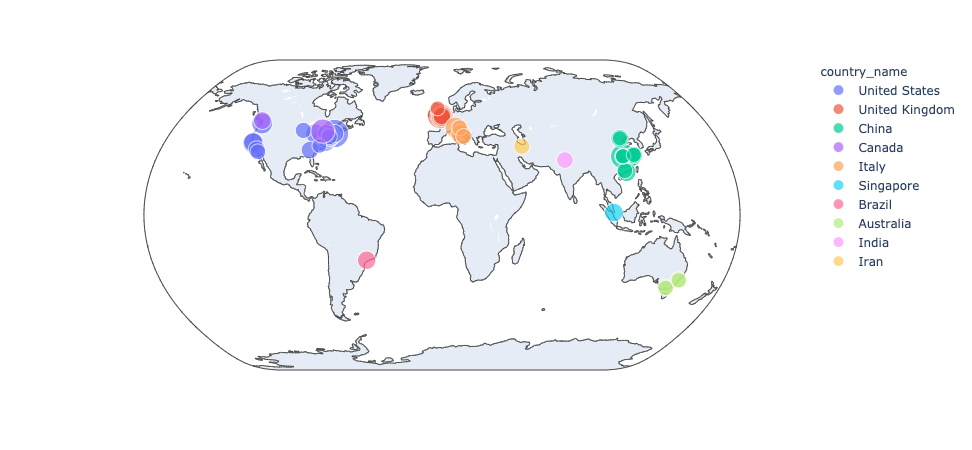

In [28]:
fig = px.scatter_geo(df, 
                     lat="latitude", lon="longitude",
                     color="country_name",
                     size="count", 
                     projection="natural earth",
                     hover_name="name",
                     hover_data=['city_name', 'id', 'types']
                     )
fig.show()

## 3. A closer look at the organizations data statistics

The Dimensions Search Language [exposes programmatically metadata](https://docs.dimensions.ai/dsl/data.html#getting-documentation-programmatically), such as supported sources and entities, along with their fields, facets, fieldsets, metrics and search fields. 

In [19]:
%dsldocs organizations

,sources,field,type,description,is_filter,is_entity,is_facet
0,organizations,acronym,string,"GRID acronym of the organization. E.g., ""UT"" f...",True,False,False
1,organizations,city_name,string,"GRID name of the organization country. E.g., ""...",True,False,True
2,organizations,cnrs_ids,string,CNRS IDs for this organization,True,False,False
3,organizations,country_name,string,"GRID name of the organization country. E.g., ""...",True,False,True
4,organizations,established,integer,Year when the organization was estabilished,True,False,False
5,organizations,external_ids_fundref,string,Fundref IDs for this organization,True,False,False
6,organizations,hesa_ids,string,HESA IDs for this organization,True,False,False
7,organizations,id,string,"GRID ID of the organization. E.g., ""grid.26999...",True,False,False
8,organizations,isni_ids,string,ISNI IDs for this organization,True,False,False
9,organizations,latitude,float,None,False,False,False


We can use the fields information above to draw up some quick statistics re. the organizations source. 

In order to do this, we  use the operator `is not empty` to generate automatically queries like this `search organizations where field_name is not empty return organizations limit 1` and then use the `total_count` field in the JSON we get back for our statistics. 

In [21]:
FIELDS_DATA = dsl_last_results

# one query with `is not empty` for field-filters  
q_template = """search organizations where {} is not empty return organizations[id] limit 1"""

# seed results with total number of orgs
totorgs = dsl.query("""search organizations return organizations[id] limit 1""", verbose=False).count_total
stats = [
    {'filter_by': 'All Organizations (no filter)', 'results' : totorgs}     
]

for index, row in pbar(list(FIELDS_DATA.iterrows())):
    # print("\n===", row['field'])
    q = q_template.format(row['field'], row['field'])
    res = dsl.query(q, verbose=False)
    time.sleep(0.5)
    stats.append({'filter_by': row['field'], 'results' : res.count_total})


# save to a dataframe
df = pd.DataFrame().from_dict(stats)
df.sort_values("results", inplace=True, ascending=False)
df

,filter_by,results
0,All Organizations (no filter),98902
8,id,98902
13,name,98902
4,country_name,98900
2,city_name,98829
26,types,97283
24,ror_ids,96592
10,latitude,92727
12,longitude,92727
11,linkout,92040


### Let's visualize the data with plotly

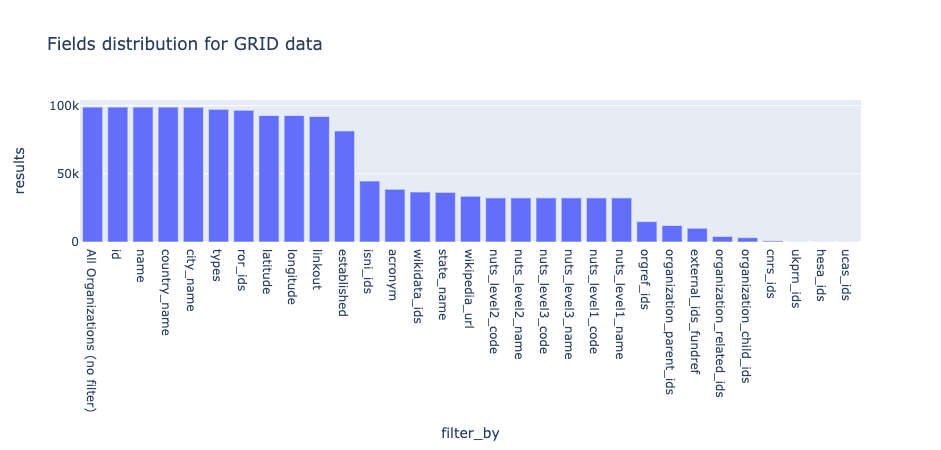

In [22]:
px.bar(df, x="filter_by", y="results", 
       title="Fields distribution for GRID data")

## Where to find out more

Please have a look at the [official documentation](https://docs.dimensions.ai/dsl/data-sources.html) for more information on the GRID source.